In [5]:
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [51]:
eu = pd.read_csv('USDKZT3.csv', sep=';', parse_dates=True, skipinitialspace=True)

eu.drop('date', axis='columns', inplace=True)
eu.head(2)
print(eu)

              open    high     low   close  volume
2013-06-26  151.70  151.70  151.70  151.70       0
2013-06-27  151.60  151.60  151.60  151.60       0
2013-06-28  151.75  151.75  151.75  151.75       0
2013-07-01  151.75  151.75  151.75  151.75       0
2013-07-02  151.85  151.85  151.85  151.85       0
...            ...     ...     ...     ...     ...
2020-05-25  414.91  415.33  413.66  414.37     209
2020-05-26  413.57  413.87  412.06  412.37     100
2020-05-27  412.37  412.77  411.27  412.47     111
2020-05-28  412.47  412.72  411.86  412.57     141
2020-05-29  412.57  412.57  411.06  411.77     110

[2201 rows x 5 columns]


In [52]:
eu.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

No handles with labels found to put in legend.


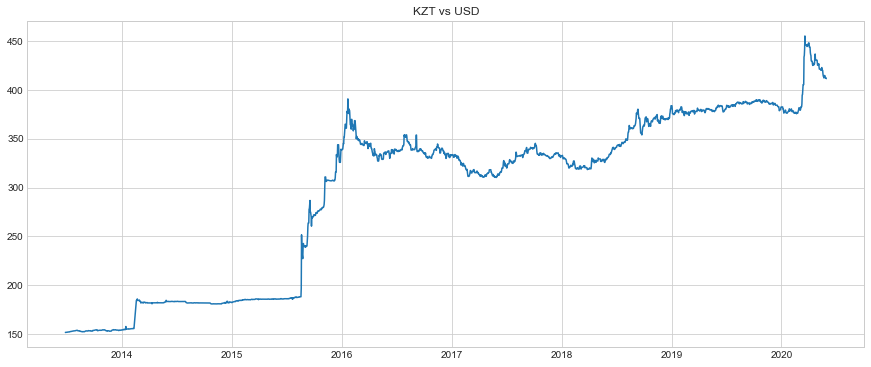

In [53]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('KZT vs USD')
plt.legend()
plt.show()

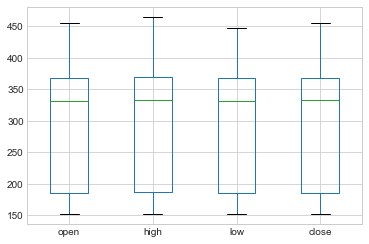

In [54]:
#box plot for open, high, low , close
eu.drop('volume', axis=1).boxplot()

In [55]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

In [56]:
#removing ouliers below
vol_cut_off =  eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

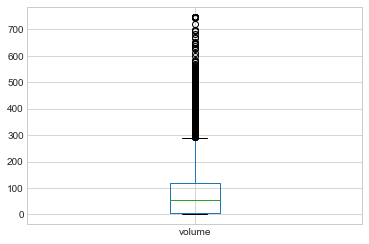

In [57]:
#boxplot for volume
eu[['volume']].boxplot()

In [58]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [59]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
2014-11-03,181.00,180.85,181.00,181.00,180.85,33.0,180.918,181.561905,182.320000,171.645278,...,0.090304,0.000663,0.000553,-0.004948,-0.013355,0.174181,1.106029e-04,-0.000213,0.000701,180.90
2014-11-04,180.90,181.00,180.90,181.00,180.90,44.0,180.922,181.516667,182.281905,171.750635,...,0.149352,-0.000552,0.000111,-0.005224,-0.013093,0.172012,2.221736e-05,-0.000209,0.000693,180.85
2014-11-05,180.85,180.90,180.85,180.90,180.85,47.0,180.902,181.461905,182.240635,171.857183,...,0.194875,-0.000276,-0.000553,-0.006319,-0.014173,0.174351,-1.104612e-04,-0.000226,0.000701,180.85
2014-11-06,180.85,180.85,180.85,180.85,180.85,54.0,180.896,181.407143,182.200476,171.966111,...,0.241160,0.000000,-0.000166,-0.006319,-0.013796,0.178944,-3.309174e-05,-0.000220,0.000717,180.88
2014-11-07,180.88,180.85,180.88,180.88,180.85,58.0,180.896,181.354762,182.160794,172.073968,...,0.284170,0.000166,0.000000,-0.006045,-0.013633,0.176838,8.492123e-08,-0.000217,0.000710,180.95


In [60]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,...,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000
mean,324.849650,324.726656,324.848721,325.424459,324.034252,124.162678,324.602663,323.605140,320.865313,309.848825,...,0.911859,0.000474,0.002382,0.010219,0.032675,0.140710,0.000475,0.000492,0.000483,324.971210
std,65.449806,65.502577,65.447613,65.679389,65.243759,161.275146,65.516325,65.751204,66.014440,67.899798,...,0.278946,0.008935,0.020142,0.044625,0.092398,0.250977,0.004043,0.001373,0.000802,65.394177
min,180.850000,180.850000,180.850000,180.850000,180.850000,1.000000,180.886000,180.920000,181.401905,171.645278,...,0.090304,-0.069130,-0.080127,-0.072848,-0.121228,-0.154731,-0.016352,-0.002008,-0.000641,180.850000
25%,316.615000,316.455000,316.660000,317.320000,316.000000,18.750000,316.426500,315.922024,315.883254,287.835923,...,0.743349,-0.000921,-0.003497,-0.006667,-0.009197,0.004212,-0.000693,-0.000141,0.000020,316.660000
50%,335.490000,335.490000,335.490000,335.995000,334.965000,62.000000,335.440000,335.394048,335.731905,330.102976,...,0.868179,0.000000,0.000539,0.001902,0.008297,0.039834,0.000108,0.000138,0.000161,335.490000
75%,375.732500,375.720000,375.732500,376.462500,374.545000,157.000000,375.697500,371.496071,369.768333,350.309276,...,1.114787,0.001331,0.004708,0.012787,0.035808,0.158213,0.000944,0.000573,0.000595,375.770000
max,455.510000,455.510000,455.510000,465.020000,447.310000,747.277233,448.310000,444.030952,430.198889,396.083135,...,1.847638,0.277017,0.337762,0.401700,0.540816,1.104980,0.064915,0.007511,0.003156,455.510000


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2014-11-03 to 2020-05-29
Data columns (total 55 columns):
open                       1884 non-null float64
open_1                     1884 non-null float64
close_1                    1884 non-null float64
high_1                     1884 non-null float64
low_1                      1884 non-null float64
volume_1                   1884 non-null float64
avg_price_5                1884 non-null float64
avg_price_30               1884 non-null float64
avg_price_90               1884 non-null float64
avg_price_365              1884 non-null float64
ratio_avg_price_5_30       1884 non-null float64
ratio_avg_price_905_       1884 non-null float64
ratio_avg_price_5_365      1884 non-null float64
ratio_avg_price_30_90      1884 non-null float64
ratio_avg_price_30_365     1884 non-null float64
ratio_avg_price_90_365     1884 non-null float64
avg_volume_5               1884 non-null float64
avg_volume_30              1884 non-null f

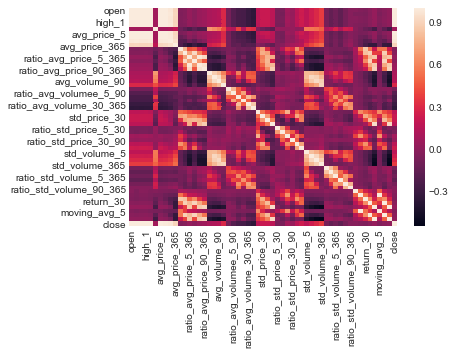

In [62]:
sns.heatmap(data.corr())

In [64]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(2013, 6, 26)
end_train = datetime.datetime(2018, 12, 31)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,...,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,304.085190,303.942349,304.083488,304.630218,303.279620,132.950453,303.801131,302.723317,299.936318,287.838287,...,0.905279,0.000574,0.002825,0.011654,0.036363,0.164513,0.000566,0.000544,0.000555,304.226224
std,61.779976,61.829941,61.775790,62.027757,61.532796,170.148970,61.838625,62.147651,62.782992,64.037445,...,0.257041,0.009883,0.021735,0.046916,0.102461,0.283128,0.004374,0.001520,0.000903,61.725665
min,180.850000,180.850000,180.850000,180.850000,180.850000,1.000000,180.886000,180.920000,181.401905,171.645278,...,0.090304,-0.069130,-0.080127,-0.072848,-0.121228,-0.154731,-0.016352,-0.002008,-0.000641,180.850000
25%,307.100000,307.062500,307.100000,307.300000,307.050000,17.250000,307.197500,297.842262,282.296429,215.411062,...,0.757546,-0.000807,-0.003621,-0.006890,-0.013608,-0.009619,-0.000723,-0.000210,-0.000030,307.112500
50%,330.085000,330.060000,330.085000,330.810000,329.460000,60.000000,330.202000,330.215714,329.083492,325.667143,...,0.855557,0.000000,0.000751,0.002788,0.008252,0.034933,0.000159,0.000136,0.000141,330.125000
75%,339.475000,339.395000,339.475000,339.857500,339.000000,203.750000,339.250000,339.235000,337.374167,333.448284,...,0.992513,0.001349,0.005392,0.016988,0.042547,0.188132,0.001078,0.000671,0.000746,339.500000
max,391.000000,391.000000,391.000000,391.000000,383.970000,747.277233,382.160000,372.839048,371.266825,352.275000,...,1.847638,0.277017,0.337762,0.401700,0.540816,1.104980,0.064915,0.007511,0.003156,391.000000


In [65]:
#segregate data for validation
start_test = datetime.datetime(2019, 1, 1, 0, 0)
end_test = datetime.datetime(2020, 5, 29, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,388.761039,388.699134,388.762489,389.427511,387.915390,97.114590,388.628160,387.877762,385.283132,377.595547,...,0.932110,0.000168,0.001017,0.005800,0.021324,0.067448,0.000197,0.000330,0.000262,388.822662
std,17.569889,17.536171,17.570408,17.931533,17.256707,126.606778,17.394073,16.379518,11.852932,9.859145,...,0.337081,0.004992,0.014087,0.036380,0.048379,0.055390,0.002773,0.000737,0.000208,17.601535
min,373.870000,373.870000,373.870000,374.770000,371.970000,1.000000,375.410000,373.527143,371.523968,352.532976,...,0.312418,-0.019758,-0.032206,-0.062962,-0.031888,-0.011649,-0.006513,-0.000512,-0.000044,373.870000
25%,379.000000,379.000000,379.000000,379.360000,378.170000,19.000000,378.861500,378.672976,378.427540,372.674038,...,0.561518,-0.001180,-0.003205,-0.006372,-0.001352,0.024828,-0.000641,-0.000019,0.000100,379.000000
50%,382.985000,382.985000,382.980000,383.570000,382.615000,66.500000,383.030000,381.961190,381.835000,379.992063,...,1.056294,0.000000,0.000000,0.000531,0.008514,0.047810,0.000002,0.000140,0.000192,382.980000
75%,387.657500,387.650000,387.687500,387.947500,387.060000,128.750000,387.564500,387.070476,387.282857,383.924544,...,1.216265,0.001282,0.003188,0.006874,0.016459,0.113143,0.000646,0.000267,0.000437,387.700000
max,455.510000,455.510000,455.510000,465.020000,447.310000,747.277233,448.310000,444.030952,430.198889,396.083135,...,1.406072,0.069761,0.122858,0.210304,0.196632,0.203819,0.023756,0.002906,0.000748,455.510000


In [66]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1422, 54), (462, 54), (1422,), (462,))

In [67]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [68]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 2.493
MAE: 1.589
R^2: 0.980


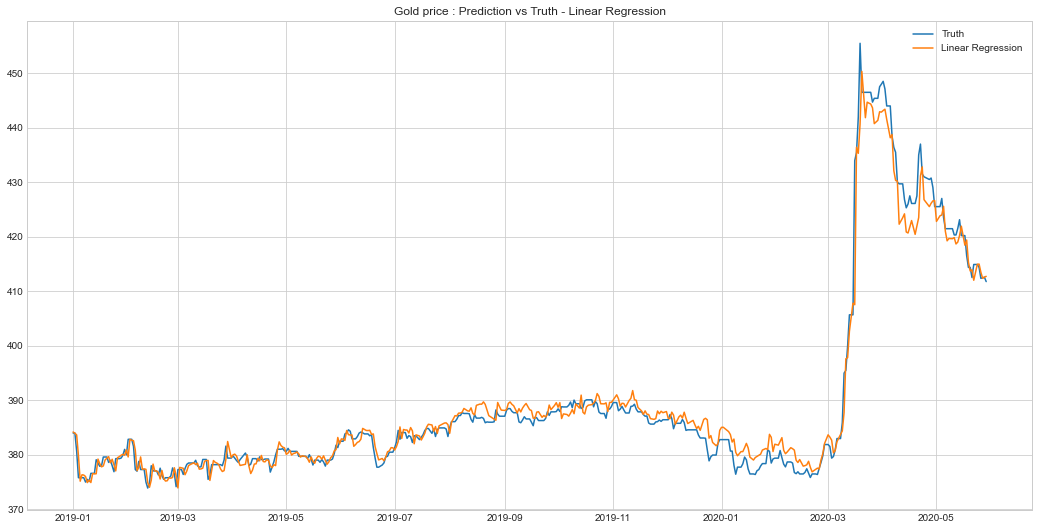

In [69]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

In [70]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 1e-05, 'eta0': 0.01, 'penalty': 'l1'}
RMSE: 2.897
MAE: 1.591
R^2: 0.973


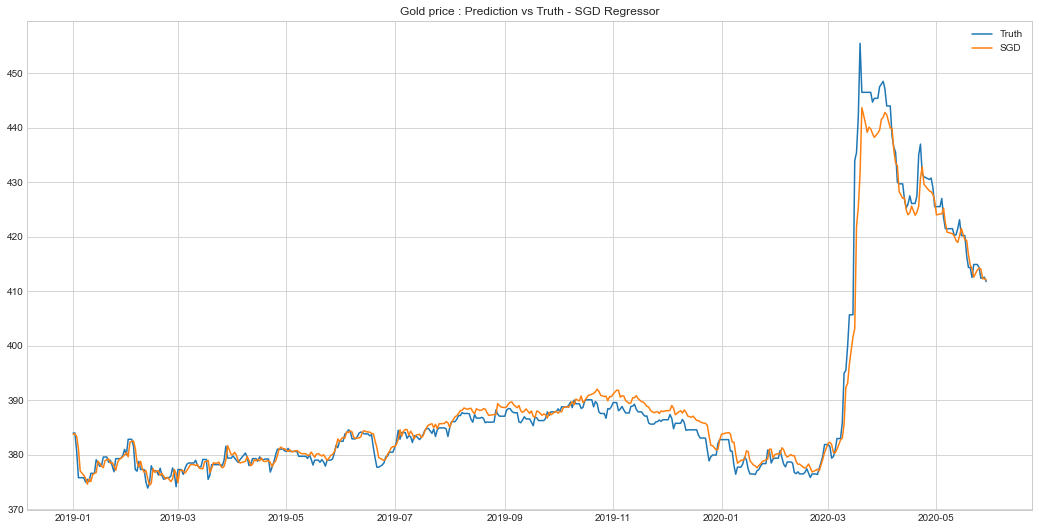

In [71]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

In [80]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 150, 250],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   25.8s finished


[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'learning_rate': 1, 'n_estimators': 100, 'subsample': 0.3}
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 20.129
MAE: 13.668
R^2: -0.311


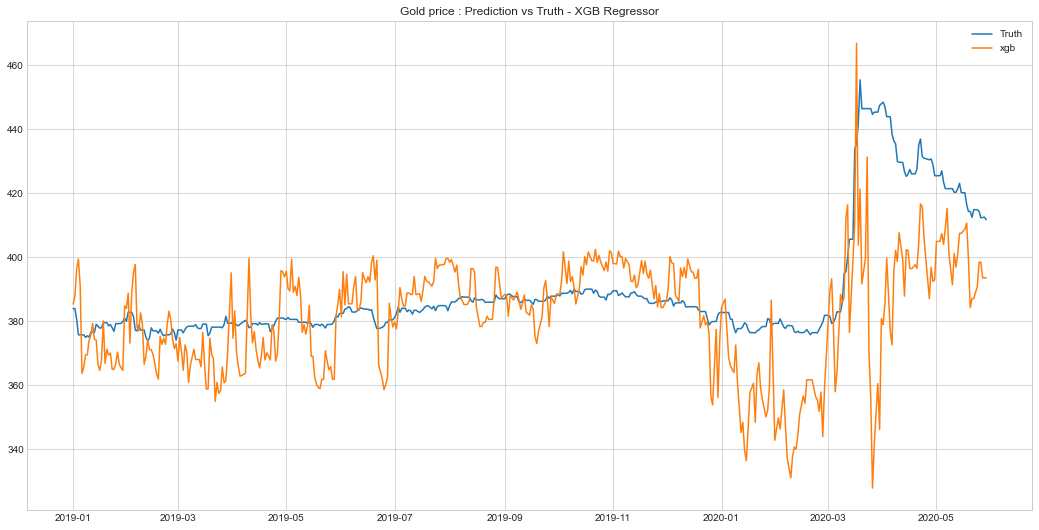

In [81]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

In [82]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 2.350
MAE: 1.470
R^2: 0.982


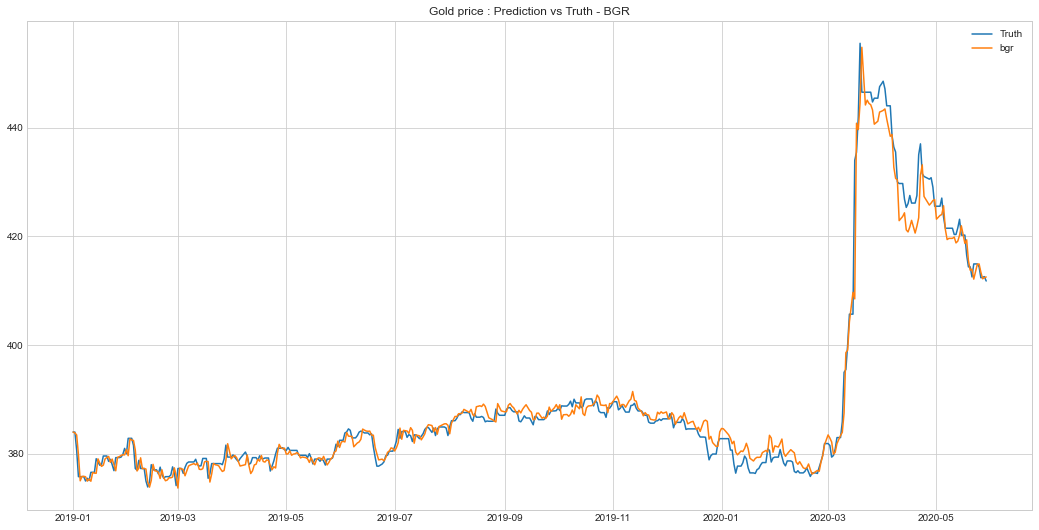

In [83]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

In [91]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=1000)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 30, 'min_samples_split': 5}
RMSE: 20.630
MAE: 10.980
R^2: -0.377


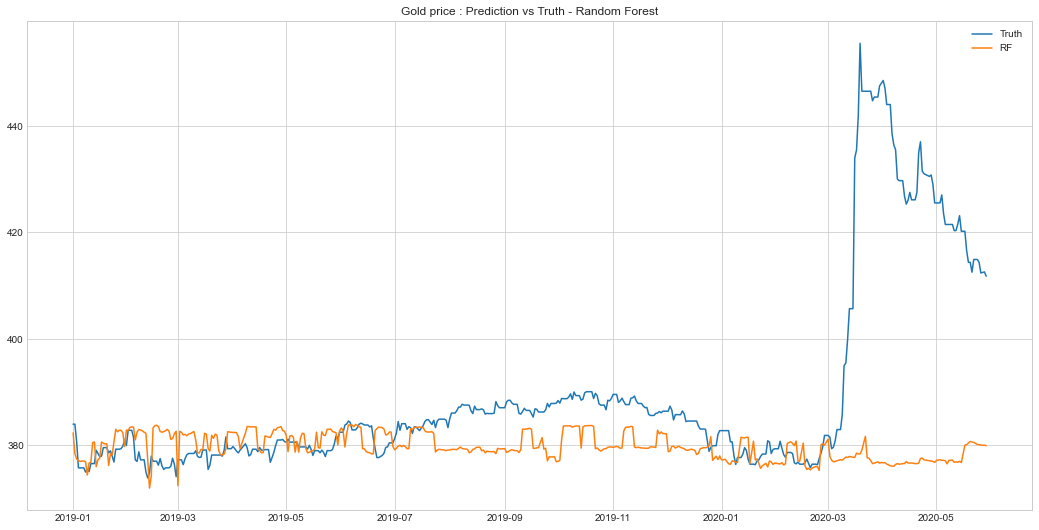

In [92]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

In [93]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_usdkzt.pkl')

['bgr_usdkzt.pkl']

In [94]:
#loading the saved model
model = joblib.load('bgr_usdkzt.pkl')

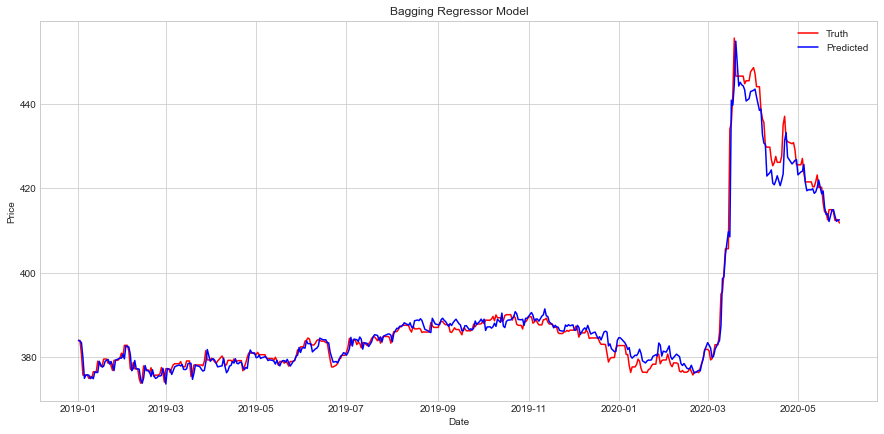

In [95]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

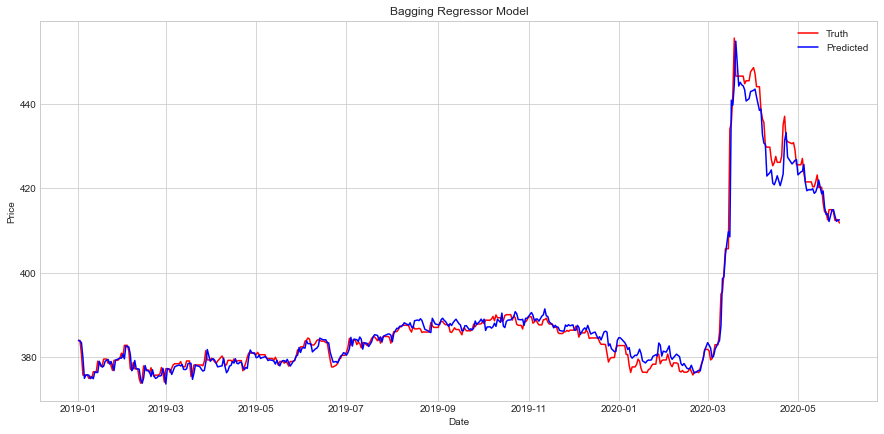

In [96]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()